In [1]:
# Calcula y compara los indices ENSO.

import pandas as pd

from io import StringIO
from scipy import stats
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'SOI')

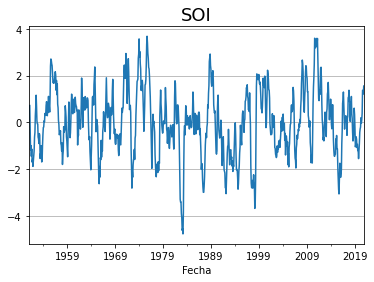

In [2]:
# Cálculo de SOI (Southern Oscillation Index)

# Datos:
# https://www.cpc.ncep.noaa.gov/data/indices/darwin
# https://www.cpc.ncep.noaa.gov/data/indices/tahiti

path = "../datos/"
places = ["tahiti", "darwin"]
name = "_mod_1951-2020.dat"

cols = ["Year"]
# Se añaden a las columnas los meses por número.
cols += list(map(lambda i: str(i), range(1,13)))

# Se lee el archivo .dat y se ajusta su formato.
df = []
fname = []
df_SOI = pd.DataFrame()
i = 0

# Se lee la presión atmosférica en cada lugar.
for i in range(0, 2):
    fname.append("slp_" + places[i] + name)
    df.append(pd.read_table(path + fname[i],
        sep = "\s+", names = cols))
    df[i] = df[i].set_index("Year")
    # Se calcula la anomalía estandarizada.
    df[i] = stats.zscore(df[i])
    # Se crea un multiíndice con el número de mes.
    df_SOI[places[i]] = df[i].stack()

# Se calcula el SOI restando ambas anomalías y
# calculando la media móvil a 3 meses.
df_SOI["SOI"] = ((df_SOI.tahiti - df_SOI.darwin)
    .rolling(window = 3).mean())

# Todos los índices se convierten en columnas.
df_SOI = df_SOI.reset_index()
# Se crea un nuevo índice de fecha a partir del año y
# el número de mes.
df_SOI["Fecha"] = pd.to_datetime(df_SOI.Year.astype(str)
    + df_SOI.level_1.astype(str), format = "%Y%m")
df_SOI = (df_SOI.set_index("Fecha")
    .drop(["Year", "level_1"], axis = 1))

# Se grafica el índice.
df_SOI.SOI.plot()
plt.grid(axis = "y")
plt.title("SOI", fontsize = "18")

Text(0.5, 1.0, 'ONI')

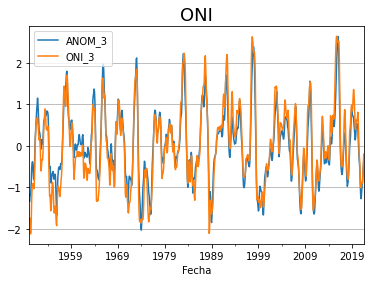

In [3]:
# Cálculo de ONI (Oceanic Niño Index)

# Datos:
# https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/
# ensostuff/detrend.nino34.ascii.txt

path = "../datos/"
fname = "detrend.nino34.ascii.txt"

# Se lee el archivo .dat y se ajusta su formato.
df_ONI = pd.read_table(path + fname, sep = "\s+")
df_ONI.set_index(["YR", "MON"], inplace = True)
# Se calcula la anomalía estandarizada.
# Se debe desdoblar el DataFrame por mes como
# columnas para podeer hacer el cálculo en Scipy.
df_T = stats.zscore(
    df_ONI["TOTAL"].unstack(),
    nan_policy = "omit")
# Se crea un multiíndice con el número de mes.
df_ONI["ONI"] = df_T.stack()

# Todos los índices se convierten en columnas.
df_ONI = df_ONI.reset_index()
# Se crea un nuevo índice de fecha a partir del año y
# el número de mes.
df_ONI["Fecha"] = pd.to_datetime(df_ONI.YR.astype(str)
    + "" + df_ONI.MON.astype(str), format = "%Y%m")
df_ONI = (df_ONI.set_index("Fecha")
    .drop(["YR", "MON"], axis = 1))

# Se calcula la media móvil a 3 meses.
df_ONI["ONI_3"] = (df_ONI.ONI
    .rolling(window = 3).mean())
# ANOM es el ONI precalculado de origen.
df_ONI["ANOM_3"] = (df_ONI.ANOM
    .rolling(window = 3).mean())

# Se grafica el índice.
df_ONI.loc[:, ["ANOM_3", "ONI_3"]].plot()
plt.grid(axis = "y")
plt.title("ONI", fontsize = "18")

Text(0.5, 1.0, 'MEI')

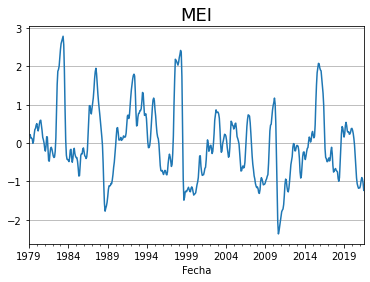

In [4]:
# Graficado de MEI.v2 (Multivariate ENSO Index Version 2 (MEI.v2)

# Datos:
# https://psl.noaa.gov/enso/mei/data/meiv2.data

path = "../datos/"
fname = "meiv2.data"

df_MEI = pd.DataFrame()

# Se lee el archivo como una cadena de texto.
with open(path + fname, "r") as f:
    data = f.read()

# Se elimina el encabezado y el pie y se carga
# en un DataFrame.
df = pd.read_table(StringIO(
    data[14:-161]), sep = "\s+", names = cols,
    index_col = "Year", na_values = -999.00)
# Se crea un multiíndice con el número de mes.
df = df.stack()

# Todos los índices se convierten en columnas.
df = df.reset_index()
# Se crea un nuevo índice de fecha a partir del año y
# el número de mes.
df["Fecha"] = pd.to_datetime(df.Year.astype(str)
    + df.level_1.astype(str), format = "%Y%m")
df = (df.set_index("Fecha")
    .drop(["Year", "level_1"], axis = 1))

# Se calcula la media móvil a 3 meses.
df_MEI["MEI"] = df.rolling(window = 3).mean()

# Se grafica el índice.
df_MEI.MEI.plot()
plt.grid(axis = "y")
plt.title("MEI", fontsize = "18")

Correlación SOI-ONI: 0.822
Correlación SOI-MEI: 0.885
Correlación MEI-ONI: 0.919


Text(0.5, 1.0, 'Indicadores ENSO')

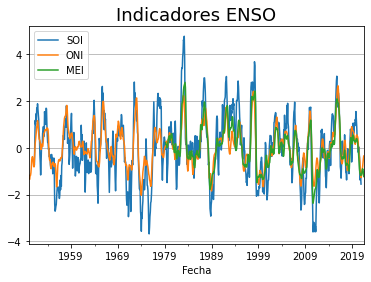

In [5]:
# Se comparan los diferentes índices ENSO.

df_ENSO = pd.concat(
    [-df_SOI.SOI, df_ONI.ANOM_3, df_MEI.MEI],
    axis = 1)
df_ENSO = df_ENSO.rename(columns = {"ANOM_3": "ONI"})

# Correlaciones.
print("Correlación SOI-ONI: "
    + f"{df_ENSO.corr().iat[1, 0]:.3f}")
print("Correlación SOI-MEI: "
    + f"{df_ENSO.corr().iat[2, 0]:.3f}")
print("Correlación MEI-ONI: "
    + f"{df_ENSO.corr().iat[2, 1]:.3f}")

df_ENSO.plot()
plt.grid(axis = "y")
plt.title("Indicadores ENSO", fontsize = "18")